In [ ]:
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 34.3 MB/s 
     |████████████████████████████████| 120 kB 78.6 MB/s 
     |████████████████████████████████| 6.6 MB 69.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 38.2 MB/s 


#목차
가장 처음 학습은 주가 타이틀이나 기사컨텐츠를 보고 긍정적인 문장인지, 부정적인 문장인지 분류할 수 있도록 구어체로 감정표현이 많이 드러난 문장들을 대상으로 경연Bert모델에 긍/부정 감정을 풍부하게 만듭니다. 
<b>1) 네이버 감성분석 데이터 불러오기 및 전처리 
2) BERT 인풋 만들기 
3) 버트를 활용한 감성분석 모델 만들기 
4) 훈련 및 성능 검증 
5) 실제 데이터로 테스트해보기
6) 감정이 학습된 Bert Model Weight 파일로 저장( 추후, 기사 타이틀 학습의 사전 모델로 사용됨) 

In [ ]:
DOC_PATH = '/content/drive/My Drive/Colab Notebooks/hyeonsang/'  ##colab 기준으로 작성했습니다. /content/drive/My Drive/Colab Notebooks/hyeonsang/

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import *
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import logging
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
tf.get_logger().setLevel(logging.ERROR)
logging.basicConfig(level=logging.ERROR)
import sentencepiece as spm

## 구글드라이브 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 네이버 영화 감성분석 데이터를 github에서 다운
- Train data : 150000 
- Test data : 50000
- All reviews are shorter than 140 characters
- Each sentiment class is sampled equally (i.e., random guess yields 50% accuracy)
-- 100K negative reviews (originally reviews of ratings 1-4)
-- 100K positive reviews (originally reviews of ratings 9-10)
-- Neutral reviews (originally reviews of ratings 5-8) are excluded

In [ ]:
!git clone https://github.com/e9t/nsmc.git

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 12.74 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [ ]:
os.listdir('nsmc')
G_SEQ_LEN = 64

In [ ]:
train = pd.read_table("nsmc/"+"ratings_train.txt")
test = pd.read_table("nsmc/"+"ratings_test.txt")

In [ ]:
train[50:70]

,id,document,label
50,9063648,영화가 사람의 영혼을 어루만져 줄 수도 있군요 거친 세상사를 잠시 잊고 동화같은 영...,1
51,8272095,야 세르게이! 작은고추의 매운맛을 보여주마! 포퐁저그 콩진호가 간다,0
52,2345905,이렇게 가슴시리게 본 드라마가 또 있을까? 감동 그 자체!,1
53,7865630,"난또 저 꼬마애가 무슨 원한이 깊길래.,. 했더니 OO 그냥 혼자 나대다 OO걸 어...",0
54,7207064,재미있어요,1
55,5719655,전 좋아요,1
56,1651126,최고,0
57,7246040,너무 충격적이엇다. 기분을 완전히 푹 꺼지게 하는 느낌... 활력이라고는 하나도 없...,1
58,717775,심심한영화.,0
59,8317483,백봉기 언제나오나요?,1


In [ ]:
#코버트간다. 
import logging
import os
import unicodedata
from shutil import copyfile

from transformers import PreTrainedTokenizer


logger = logging.getLogger(__name__)

VOCAB_FILES_NAMES = {"vocab_file": "tokenizer_78b3253a26.model",
                     "vocab_txt": "vocab.txt"}

PRETRAINED_VOCAB_FILES_MAP = {
    "vocab_file": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/tokenizer_78b3253a26.model",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/tokenizer_78b3253a26.model",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/tokenizer_78b3253a26.model"
    },
    "vocab_txt": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/vocab.txt",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/vocab.txt",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/vocab.txt"
    }
}

PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    "monologg/kobert": 512,
    "monologg/kobert-lm": 512,
    "monologg/distilkobert": 512
}

PRETRAINED_INIT_CONFIGURATION = {
    "monologg/kobert": {"do_lower_case": False},
    "monologg/kobert-lm": {"do_lower_case": False},
    "monologg/distilkobert": {"do_lower_case": False}
}

SPIECE_UNDERLINE = u'▁'


class KoBertTokenizer(PreTrainedTokenizer):
    """
        SentencePiece based tokenizer. Peculiarities:
            - requires `SentencePiece <https://github.com/google/sentencepiece>`_
    """
    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    pretrained_init_configuration = PRETRAINED_INIT_CONFIGURATION
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES

    def __init__(
            self,
            vocab_file,
            vocab_txt,
            do_lower_case=False,
            remove_space=True,
            keep_accents=False,
            unk_token="[UNK]",
            sep_token="[SEP]",
            pad_token="[PAD]",
            cls_token="[CLS]",
            mask_token="[MASK]",
            **kwargs):
        super().__init__(
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            **kwargs
        )

        # Build vocab
        self.token2idx = dict()
        self.idx2token = []
        with open(vocab_txt, 'r', encoding='utf-8') as f:
            for idx, token in enumerate(f):
                token = token.strip()
                self.token2idx[token] = idx
                self.idx2token.append(token)

        #self.max_len_single_sentence = self.max_len - 2  # take into account special tokens
        #self.max_len_sentences_pair = self.max_len - 3  # take into account special tokens

        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")

        self.do_lower_case = do_lower_case
        self.remove_space = remove_space
        self.keep_accents = keep_accents
        self.vocab_file = vocab_file
        self.vocab_txt = vocab_txt

        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(vocab_file)

    @property
    def vocab_size(self):
        return len(self.idx2token)

    def __getstate__(self):
        state = self.__dict__.copy()
        state["sp_model"] = None
        return state

    def __setstate__(self, d):
        self.__dict__ = d
        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(self.vocab_file)

    def preprocess_text(self, inputs):
        if self.remove_space:
            outputs = " ".join(inputs.strip().split())
        else:
            outputs = inputs
        outputs = outputs.replace("``", '"').replace("''", '"')

        if not self.keep_accents:
            outputs = unicodedata.normalize('NFKD', outputs)
            outputs = "".join([c for c in outputs if not unicodedata.combining(c)])
        if self.do_lower_case:
            outputs = outputs.lower()

        return outputs

    def _tokenize(self, text, return_unicode=True, sample=False):
        """ Tokenize a string. """
        text = self.preprocess_text(text)

        if not sample:
            pieces = self.sp_model.EncodeAsPieces(text)
        else:
            #pieces = self.sp_model.SampleEncodeAsPieces(text, 64, 0.1)
            pieces = self.sp_model.SampleEncodeAsPieces(text, G_SEQ_LEN, 0)
        new_pieces = []
        for piece in pieces:
            if len(piece) > 1 and piece[-1] == str(",") and piece[-2].isdigit():
                cur_pieces = self.sp_model.EncodeAsPieces(piece[:-1].replace(SPIECE_UNDERLINE, ""))
                if piece[0] != SPIECE_UNDERLINE and cur_pieces[0][0] == SPIECE_UNDERLINE:
                    if len(cur_pieces[0]) == 1:
                        cur_pieces = cur_pieces[1:]
                    else:
                        cur_pieces[0] = cur_pieces[0][1:]
                cur_pieces.append(piece[-1])
                new_pieces.extend(cur_pieces)
            else:
                new_pieces.append(piece)

        return new_pieces

    def _convert_token_to_id(self, token):
        """ Converts a token (str/unicode) in an id using the vocab. """
        return self.token2idx.get(token, self.token2idx[self.unk_token])

    def _convert_id_to_token(self, index, return_unicode=True):
        """Converts an index (integer) in a token (string/unicode) using the vocab."""
        return self.idx2token[index]

    def convert_tokens_to_string(self, tokens):
        """Converts a sequence of tokens (strings for sub-words) in a single string."""
        out_string = "".join(tokens).replace(SPIECE_UNDERLINE, " ").strip()
        return out_string

    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A RoBERTa sequence has the following format:
            single sequence: [CLS] X [SEP]
            pair of sequences: [CLS] A [SEP] B [SEP]
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens=False):
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.
        Args:
            token_ids_0: list of ids (must not contain special tokens)
            token_ids_1: Optional list of ids (must not contain special tokens), necessary when fetching sequence ids
                for sequence pairs
            already_has_special_tokens: (default False) Set to True if the token list is already formated with
                special tokens for the model
        Returns:
            A list of integers in the range [0, 1]: 0 for a special token, 1 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]

    def create_token_type_ids_from_sequences(self, token_ids_0, token_ids_1=None):
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A BERT sequence pair mask has the following format:
        0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
        | first sequence    | second sequence
        if token_ids_1 is None, only returns the first portion of the mask (0's).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]

    def save_vocabulary(self, save_directory):
        """ Save the sentencepiece vocabulary (copy original file) and special tokens file
            to a directory.
        """
        if not os.path.isdir(save_directory):
            logger.error("Vocabulary path ({}) should be a directory".format(save_directory))
            return

        # 1. Save sentencepiece model
        out_vocab_model = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_file"])

        if os.path.abspath(self.vocab_file) != os.path.abspath(out_vocab_model):
            copyfile(self.vocab_file, out_vocab_model)

        # 2. Save vocab.txt
        index = 0
        out_vocab_txt = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_txt"])
        with open(out_vocab_txt, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.token2idx.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".format(out_vocab_txt)
                    )
                    index = token_index
                writer.write(token + "\n")
                index += 1

        return out_vocab_model, out_vocab_txt

In [ ]:
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension
#tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')
tokenizer = KoBertTokenizer.from_pretrained('HyeonSang/kobert-sentiment')

https://huggingface.co/HyeonSang/kobert-sentiment/resolve/main/tokenizer_78b3253a26.model not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp9nsl2pi0


storing https://huggingface.co/HyeonSang/kobert-sentiment/resolve/main/tokenizer_78b3253a26.model in cache at /root/.cache/huggingface/transformers/43bbee2de615a89368e6f67ad57d91bf62b36f0347dd2b4a099b47dab6effec7.3298791184927769289badb2a4fa1a4e2c58e4b032da9b4d3d29faeb2e5b0cda
creating metadata file for /root/.cache/huggingface/transformers/43bbee2de615a89368e6f67ad57d91bf62b36f0347dd2b4a099b47dab6effec7.3298791184927769289badb2a4fa1a4e2c58e4b032da9b4d3d29faeb2e5b0cda
https://huggingface.co/HyeonSang/kobert-sentiment/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp5_lie9vs


storing https://huggingface.co/HyeonSang/kobert-sentiment/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/0a97c0f685d07f9fa4ee7968a2c802a156f1b82d1c2b44c81ebf5a8e49a65d6a.9cad641b304b5ad278af344eb08848d342da168ced6ad4f5fbb38486b3410e86
creating metadata file for /root/.cache/huggingface/transformers/0a97c0f685d07f9fa4ee7968a2c802a156f1b82d1c2b44c81ebf5a8e49a65d6a.9cad641b304b5ad278af344eb08848d342da168ced6ad4f5fbb38486b3410e86
https://huggingface.co/HyeonSang/kobert-sentiment/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpnx8qilzm


storing https://huggingface.co/HyeonSang/kobert-sentiment/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/3a6d42dde7a5003d2fa07279c0733d3b4c9be8f093fd649a275f037885e5778b.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
creating metadata file for /root/.cache/huggingface/transformers/3a6d42dde7a5003d2fa07279c0733d3b4c9be8f093fd649a275f037885e5778b.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
https://huggingface.co/HyeonSang/kobert-sentiment/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpsx07ks70


storing https://huggingface.co/HyeonSang/kobert-sentiment/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/de228ccdeeeb95c5e8fd03d3b52de4390ce93a531d11076ca673c0bce49e3c7e.d041aee5e462fc23a0c0c950e5022a0036d097d607dca1432a41c996f34f10d8
creating metadata file for /root/.cache/huggingface/transformers/de228ccdeeeb95c5e8fd03d3b52de4390ce93a531d11076ca673c0bce49e3c7e.d041aee5e462fc23a0c0c950e5022a0036d097d607dca1432a41c996f34f10d8
loading file https://huggingface.co/HyeonSang/kobert-sentiment/resolve/main/tokenizer_78b3253a26.model from cache at /root/.cache/huggingface/transformers/43bbee2de615a89368e6f67ad57d91bf62b36f0347dd2b4a099b47dab6effec7.3298791184927769289badb2a4fa1a4e2c58e4b032da9b4d3d29faeb2e5b0cda
loading file https://huggingface.co/HyeonSang/kobert-sentiment/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0a97c0f685d07f9fa4ee7968a2c802a156f1b82d1c2b44c81ebf5a8e49a65d6a.9cad641b304b5ad278af344eb08848d342da168ced6a

storing https://huggingface.co/HyeonSang/kobert-sentiment/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/2e4d8b8998ae5495745c8f58870dbb268ad954a9517f4d35f835b78453df6c65.0d9d6237228c60750b87bf4651a0e16d2102c4181827c2cfe1291860903d9a98
creating metadata file for /root/.cache/huggingface/transformers/2e4d8b8998ae5495745c8f58870dbb268ad954a9517f4d35f835b78453df6c65.0d9d6237228c60750b87bf4651a0e16d2102c4181827c2cfe1291860903d9a98
loading configuration file https://huggingface.co/HyeonSang/kobert-sentiment/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/2e4d8b8998ae5495745c8f58870dbb268ad954a9517f4d35f835b78453df6c65.0d9d6237228c60750b87bf4651a0e16d2102c4181827c2cfe1291860903d9a98
Model config BertConfig {
  "_name_or_path": "HyeonSang/kobert-sentiment",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dro

In [ ]:
print(tokenizer.tokenize("전율을 일으키는 영화. 다시 보고싶은 영화"))

['▁전', '율을', '▁일으키', '는', '▁영화', '.', '▁다시', '▁보고', '싶', '은', '▁영화']


In [ ]:
print(tokenizer.encode("전율을 일으키는 영화. 다시 보고싶은 영화"))

[2, 4012, 7071, 3815, 5760, 3394, 54, 1574, 2358, 6751, 7086, 3394, 3]


In [ ]:
print(tokenizer.encode("전율을 일으키는 영화. 다시 보고싶은 영화", max_length=G_SEQ_LEN, pad_to_max_length=True, truncation=True))

[2, 4012, 7071, 3815, 5760, 3394, 54, 1574, 2358, 6751, 7086, 3394, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# 세그멘트 인풋
print([0]*G_SEQ_LEN)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
# 마스크 인풋
valid_num = len(tokenizer.encode("전율을 일으키는 영화. 다시 보고싶은 영화"))
print(valid_num * [1] + (G_SEQ_LEN - valid_num) * [0])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# 활용함수는 아래 정의

In [ ]:
def convert_data(data_df):
    global tokenizer
    
    SEQ_LEN = G_SEQ_LEN #SEQ_LEN : 버트에 들어갈 인풋의 길이
    
    tokens, masks, segments, targets = [], [], [], []
    
    for i in tqdm(range(len(data_df))):
        # token : 문장을 토큰화함
        #token = tokenizer.encode(data_df[DATA_COLUMN][i], max_length=SEQ_LEN, pad_to_max_length=True)
        token = tokenizer.encode(data_df[DATA_COLUMN][i], max_length=SEQ_LEN, pad_to_max_length=True, truncation=True)
       
        # 마스크는 토큰화한 문장에서 패딩이 아닌 부분은 1, 패딩인 부분은 0으로 통일
        num_zeros = token.count(0)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
        
        # 문장의 전후관계를 구분해주는 세그먼트는 문장이 1개밖에 없으므로 모두 0
        segment = [0]*SEQ_LEN

        # 버트 인풋으로 들어가는 token, mask, segment를 tokens, segments에 각각 저장
        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        
        # 정답(긍정 : 1 부정 0)을 targets 변수에 저장해 줌
        targets.append(data_df[LABEL_COLUMN][i])

    # tokens, masks, segments, 정답 변수 targets를 numpy array로 지정    
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets

# 위에 정의한 convert_data 함수를 불러오는 함수를 정의
def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_df[LABEL_COLUMN] = data_df[LABEL_COLUMN].astype(int)
    data_x, data_y = convert_data(data_df)
    return data_x, data_y
    
def dfJHSSentanceInspect(_column):
    list = _column.tolist()
    tokenized_list = [r.split() for r in list]
    sentence_len_by_token = [len(t) for t in tokenized_list]
    sentence_len_by_eumjeol = [len(s.replace(' ', '')) for s in list]
    
    plt.figure(figsize = (12,5)) 
    plt.hist(sentence_len_by_token, bins = 50, alpha=0.5, color="r", label="word") 
    plt.hist(sentence_len_by_eumjeol, bins = 50, alpha=0.5, color="b", label="aplt.yscallphabet") 
    plt.yscale('log', nonposy = 'clip') 
    plt.title(_column.name) 
    plt.xlabel('red:token / blue:eumjeol length') 
    plt.ylabel('number of sentences')

    
    print('\n', ) 
    print('칼럼명 : {}'.format(_column.name)) 
    print('토큰 최대 길이 : {}'.format(np.max(sentence_len_by_token))) 
    print('토큰 최소 길이 : {}'.format(np.min(sentence_len_by_token))) 
    print('토큰 평균 길이 : {:.2f}'.format(np.mean(sentence_len_by_token))) 
    print('토큰 길이 표준편차 : {:.2f}'.format(np.std(sentence_len_by_token))) 
    print('토큰 중간 길이 : {}'.format(np.median(sentence_len_by_token))) 
    print('제 1사분위 길이 : {}'.format(np.percentile(sentence_len_by_token, 25))) 
    print('제 3사분위 길이 : {}'.format(np.percentile(sentence_len_by_token, 75)))
    print('빨간색 히스토그램은 토큰 개수에 대한 히스토그램: EX> 나는 아침밥을 먹었다 -> 3 ')
    print('파란색 음절 개수의 히스토그램 EX> 나는 아침밥을 먹었다-> 9' )

# train의 문장 분포를 검사합니다. 
- 경연에서 주어진 meta.dill과 비슷한 분포를 보이고 있어 transfer learning시 기사 문장에 잘 학습 fit할 것으로 보임

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of Series.dropna will be keyword-only
  """Entry point for launching an IPython kernel.




칼럼명 : document
토큰 최대 길이 : 41
토큰 최소 길이 : 1
토큰 평균 길이 : 7.59
토큰 길이 표준편차 : 6.51
토큰 중간 길이 : 6.0
제 1사분위 길이 : 3.0
제 3사분위 길이 : 9.0
빨간색 히스토그램은 토큰 개수에 대한 히스토그램: EX> 나는 아침밥을 먹었다 -> 3 
파란색 음절 개수의 히스토그램 EX> 나는 아침밥을 먹었다-> 9


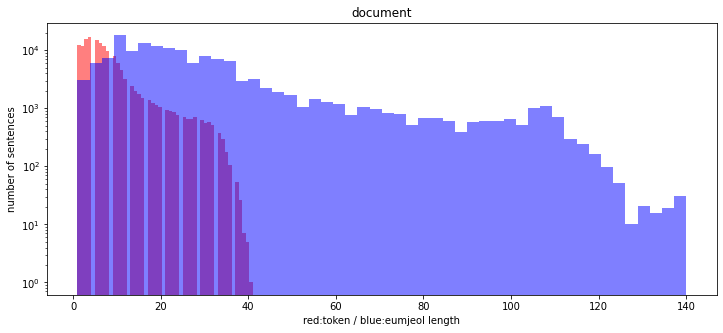

In [ ]:
dfJHSSentanceInspect(train.document.dropna(''))

In [ ]:
print(train.shape)
print(test.shape)

(150000, 3)
(50000, 3)


In [ ]:
SEQ_LEN = G_SEQ_LEN
BATCH_SIZE = 32
# 긍부정 문장을 포함하고 있는 칼럼
DATA_COLUMN = "document"
# 긍정인지 부정인지를 (1=긍정,0=부정) 포함하고 있는 칼럼
LABEL_COLUMN = "label"


In [ ]:
# train 데이터를 버트 인풋에 맞게 변환
#집보다 느린건 참을수가 없다. 
train_x, train_y = load_data(train)
test_x, test_y = load_data(test)

100%|██████████| 50000/50000 [00:11<00:00, 4488.05it/s]


In [ ]:
#!pip install tensorflow_addons
#import tensorflow_addons as tfa



In [ ]:
# GPU모드사용할때 이름 찾기 
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13874956236927762635
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14444920832
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11926210150568102165
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


# 모델생성
GPU모드 사용방법


In [ ]:
# TPU 객체 만들기

#resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
#tf.config.experimental_connect_to_cluster(resolver)
#tf.tpu.experimental.initialize_tpu_system(resolver)

### 모델생성

In [ ]:
def create_sentiment_bert():
    opt = optimizers.Adam(lr=5.0e-5,  epsilon=1e-08)        
    #model = TFBertModel.from_pretrained("monologg/kobert", from_pt=True)
    model = TFBertModel.from_pretrained("HyeonSang/kobert-sentiment", from_pt=False)
    # 토큰 인풋, 마스크 인풋, 세그먼트 인풋 정의
    token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_word_ids')
    mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_masks')
    segment_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_segment')
    # 인풋이 [토큰, 마스크, 세그먼트]인 모델 정의
    bert_outputs = model([token_inputs, mask_inputs, segment_inputs])
    bert_outputs = bert_outputs[1]    
    
    sentiment_drop = tf.keras.layers.Dropout(0.5)(bert_outputs)
    sentiment_first = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(sentiment_drop)
    sentiment_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], sentiment_first)
    sentiment_model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])
    return sentiment_model

In [ ]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"],cross_device_ops=tf.distribute.HierarchicalCopyAllReduce()) #GPU모드 
print('Number of devices: {}'.format(strategy.num_replicas_in_sync)) # GPU
#strategy = tf.distribute.experimental.TPUStrategy(resolver) # TPU모드 
with strategy.scope():
    sentiment_model = create_sentiment_bert() 

Number of devices: 1


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
loading configuration file https://huggingface.co/HyeonSang/kobert-sentiment/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/2e4d8b8998ae5495745c8f58870dbb268ad954a9517f4d35f835b78453df6c65.0d9d6237228c60750b87bf4651a0e16d2102c4181827c2cfe1291860903d9a98
Model config BertConfig {
  "_name_or_path": "monologg/kobert",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embeddi

storing https://huggingface.co/HyeonSang/kobert-sentiment/resolve/main/tf_model.h5 in cache at /root/.cache/huggingface/transformers/54a224eebf5e5d2fb22916288b8ed5e7c859fffbcd8ecd764d271df63ee35336.6e8a00766d675a6d70d33d9f5119f242a66fb81279e7cc9d078e7866e46422d4.h5
creating metadata file for /root/.cache/huggingface/transformers/54a224eebf5e5d2fb22916288b8ed5e7c859fffbcd8ecd764d271df63ee35336.6e8a00766d675a6d70d33d9f5119f242a66fb81279e7cc9d078e7866e46422d4.h5
loading weights file https://huggingface.co/HyeonSang/kobert-sentiment/resolve/main/tf_model.h5 from cache at /root/.cache/huggingface/transformers/54a224eebf5e5d2fb22916288b8ed5e7c859fffbcd8ecd764d271df63ee35336.6e8a00766d675a6d70d33d9f5119f242a66fb81279e7cc9d078e7866e46422d4.h5
All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at HyeonSang/kobert-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, y

In [ ]:
sentiment_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 64)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 64)]         0           []                               
                                                                                                  
 input_segment (InputLayer)     [(None, 64)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  92186880    ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_masks[0][0]',        

In [ ]:
hist = sentiment_model.fit(train_x, train_y, epochs=4, shuffle=True, batch_size=64, validation_data=(test_x, test_y))
#hist=sentiment_model.fit(train_x, train_y, epochs=4, shuffle=True, batch_size=120, validation_split=0.1)

Epoch 1/4
2344/2344 [==============================] - 2119s 897ms/step - loss: 0.2756 - accuracy: 0.8866 - val_loss: 0.2600 - val_accuracy: 0.8942
Epoch 2/4
2344/2344 [==============================] - 2109s 900ms/step - loss: 0.2132 - accuracy: 0.9155 - val_loss: 0.2684 - val_accuracy: 0.8945
Epoch 3/4
2344/2344 [==============================] - 2107s 899ms/step - loss: 0.1650 - accuracy: 0.9373 - val_loss: 0.2876 - val_accuracy: 0.8943
Epoch 4/4
2344/2344 [==============================] - 2104s 898ms/step - loss: 0.1236 - accuracy: 0.9548 - val_loss: 0.3140 - val_accuracy: 0.8915


In [ ]:
def predict_convert_data(data_df):
    global tokenizer
    tokens, masks, segments = [], [], []
    
    for i in tqdm(range(len(data_df))):

        token = tokenizer.encode(data_df[DATA_COLUMN][i], max_length=SEQ_LEN, pad_to_max_length=True)
        num_zeros = token.count(0)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
        segment = [0]*SEQ_LEN

        tokens.append(token)
        segments.append(segment)
        masks.append(mask)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    return [tokens, masks, segments]

# 위에 정의한 convert_data 함수를 불러오는 함수를 정의
def predict_load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_x = predict_convert_data(data_df)
    return data_x

In [ ]:
print('done')

done


In [ ]:
test_set = predict_load_data(test)


100%|██████████| 50000/50000 [00:10<00:00, 4741.35it/s]


In [ ]:
test_set

[array([[   2,  517, 5515, ...,    1,    1,    1],
        [   2,  650,  278, ...,    1,    1,    1],
        [   2, 2145, 6844, ...,    1,    1,    1],
        ...,
        [   2, 1212, 5859, ...,    1,    1,    1],
        [   2, 4069, 2420, ...,    1,    1,    1],
        [   2, 1914, 5760, ...,    1,    1,    1]]),
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [ ]:
preds = sentiment_model.predict(test_set)

In [ ]:
from sklearn.metrics import classification_report
y_true = test['label']
# F1 Score 확인
print(classification_report(y_true, np.round(preds,0)))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89     24827
           1       0.91      0.87      0.89     25173

    accuracy                           0.89     50000
   macro avg       0.89      0.89      0.89     50000
weighted avg       0.89      0.89      0.89     50000



In [ ]:
import logging
tf.get_logger().setLevel(logging.ERROR)

In [ ]:
def sentence_convert_data(data):
    global tokenizer
    tokens, masks, segments = [], [], []
    token = tokenizer.encode(data, max_length=SEQ_LEN, pad_to_max_length=True, truncation=True)
    
    num_zeros = token.count(0) 
    mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros 
    segment = [0]*SEQ_LEN

    tokens.append(token)
    segments.append(segment)
    masks.append(mask)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    return [tokens, masks, segments]

def movie_evaluation_predict(sentence):
    data_x = sentence_convert_data(sentence)
    predict = sentiment_model.predict(data_x)
    predict_value = np.ravel(predict)
    predict_answer = np.round(predict_value,0).item()
    
    if predict_answer == 0:
        print("(부정 확률 : %.2f) 부정적인 문장입니다." % (1-predict_value))
    elif predict_answer == 1:
        print("(긍정 확률 : %.2f) 긍정적인 문장입니다." % predict_value)

In [ ]:
#movie_evaluation_predict("보던거라 계속보고있는데 전개도 느리고 주인공인 은희는 한두컷 나오면서 소극적인모습에 ")
movie_evaluation_predict('사랑하고싶게하는,가슴속온감정을헤집어놓는영화예요정말최고.') #이건 학습데이터 찐긍정
movie_evaluation_predict('사랑을 했는데, 가슴이 웅장해져. 최고의 영화가 아닐까 한다.') #이건 학습데이터랑 비슷한 문장으로 


(긍정 확률 : 1.00) 긍정적인 문장입니다.


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


(긍정 확률 : 1.00) 긍정적인 문장입니다.


In [ ]:
# . 내껀 센텐스 분류기다. 
movie_evaluation_predict('가 새해 첫날 외국인 투자자와 기관투자자의 동반 매수세에 힘입어 3% 이상 상승했다.') 
movie_evaluation_predict('장중 2만6650원까지 올랐다.') 
movie_evaluation_predict('장중 2만6650원까지 하락했다.') 

(긍정 확률 : 0.80) 긍정적인 문장입니다.
(긍정 확률 : 0.92) 긍정적인 문장입니다.
(부정 확률 : 0.98) 부정적인 문장입니다.


In [ ]:
sentiment_model.output_shape

In [ ]:
movie_evaluation_predict('2일 오후 12시40분 현재 뿅뿅주가는 전일대비 3.11% 오른 2만6550원에 거래 중이다.') 

In [ ]:
movie_evaluation_predict('장중 2만6650원(3.5%)까지 올랐다.') 

In [ ]:
movie_evaluation_predict('우리투자, CS, NH가 매수창구 상위에 이름을 올렸다.')

In [ ]:
movie_evaluation_predict('외국계 증권사 창구에서 9만주 이상 매수 우위를 나타냈다.')

In [ ]:
movie_evaluation_predict('이날 오전 11시 20분 기준 외국인과 기관은 SK하이닉스를 각각 18만3000주, 10만주씩 순매수한 것으로 잠정 집계됐다.')

In [ ]:
movie_evaluation_predict('최 연구원은 최근 하이닉스의 주가 변동성을 미·중 무역분쟁과 일본의 수출규제 조치 등 외부 변수에 의한 것으로 설명했다.')

### 문장을 테스트해보면 긍정적이라고 나오는 것 같지만, 감정을 추가한 모델을 이용하여 바로 모든 주가 기사 문장을 예측해보면 F1-score가 54%쯤 나왔습니다. 
- 다음 프로세스에서는 meta.dill 기사 컨텐츠정도의 길이의 네이버 영화 평론 감정 문장을 학습시킨 Bert 모델을 기반으로 기사의 핵심 내용이 담긴 제목을 학습하겠습니다. 
- 제목은 전달하고자 하는 주가 내용의 핵심이 담겨있고, 짧고 명료하게 구성되어 있으리라 가정합니다.
- 또한, 제목은 사람들의 시선을 끌기위한 감정이 섞인 (가슴이 웅장해지는) 문장으로 구성되어있으리라 가정합니다.

In [ ]:
# accuracy 조회
# accuracy가 올라가고, validation_accuracy가 내려가는 오버피팅 구간이 있는지 확인한다. 
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.plot(hist.history['accuracy'], color='r')
plt.plot(hist.history['val_accuracy'], color='b')
plt.title('accuracy')

#loss 조회
plt.subplot(2, 2, 2)
plt.plot(hist.history['loss'], color='r')
plt.plot(hist.history['val_loss'], color='b')
plt.title('loss')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
confusion_matrix(y_true, np.round(preds,0), labels=[1, 0]) #1과 0에 대한 CONFUSION_MATRIX

# 감정분류가 학습된 Bert model의 weight를 저장합니다. 
- 저장한 모델의 감정 분류 node의 coefficients들은 두번째 Process인 기사 제목(Title)을 학습하는 PreTrained Model로써 사용합니다. 
- 다음 작업은,  주가 기사의 타이틀을 학습하기 위해 경연에서 주어진 CSV파일을 이용하여, 기사 제목 데이터를 전처리하는 과정입니다. 
- 파일은, [전처리-1]CSV파일의타이틀추출및클린징.ipynb 입니다

In [ ]:
file_name = os.path.join(DOC_PATH, 'result/transfer_model/gpu_2019_process1_emotional_base_model.h5')
sentiment_model.save_weights(file_name)